In [24]:
import warnings
warnings.filterwarnings("ignore")

# Aykırı Gözlem Analizi

### Aykırı Değerleri Yakalamak

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["int64", "float64"])
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [106]:
df.shape

(53940, 7)

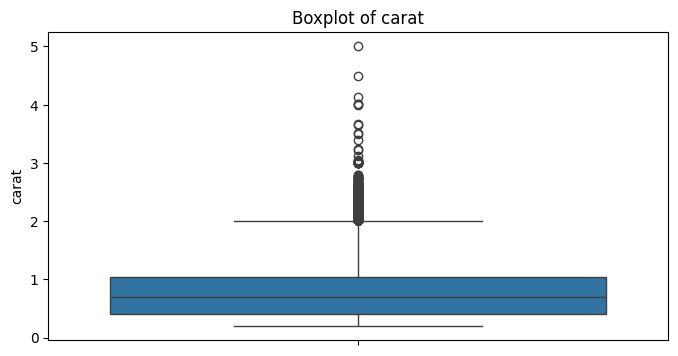

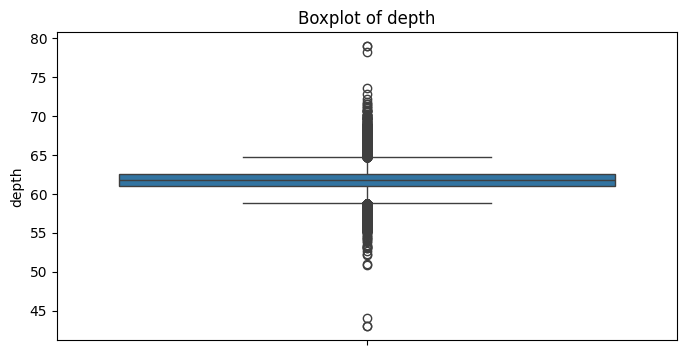

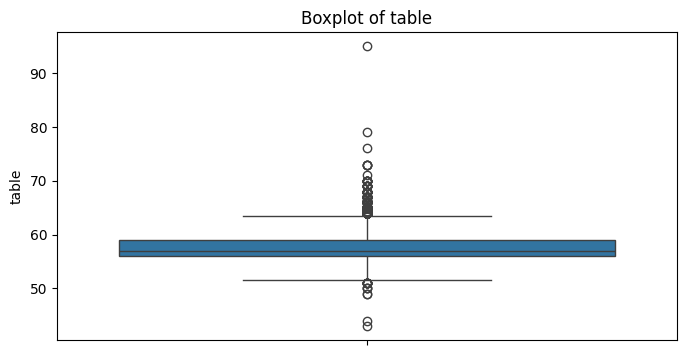

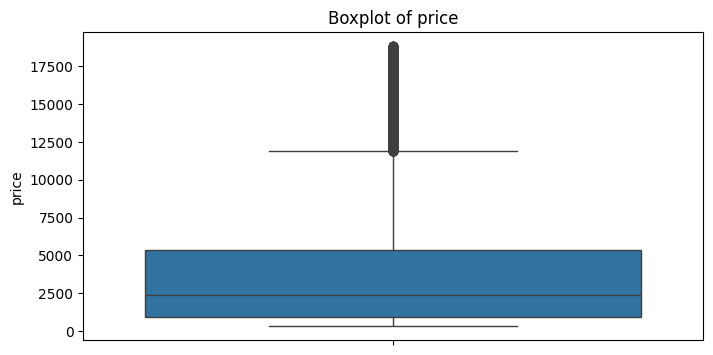

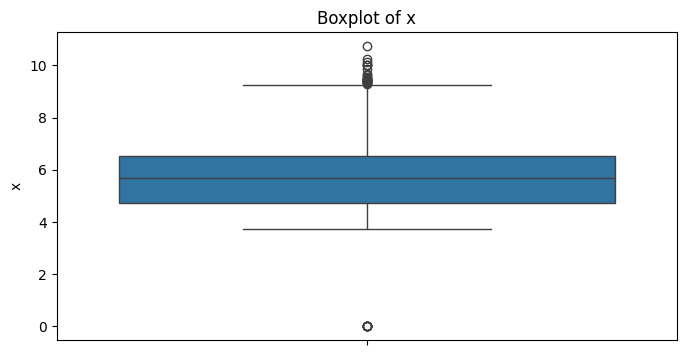

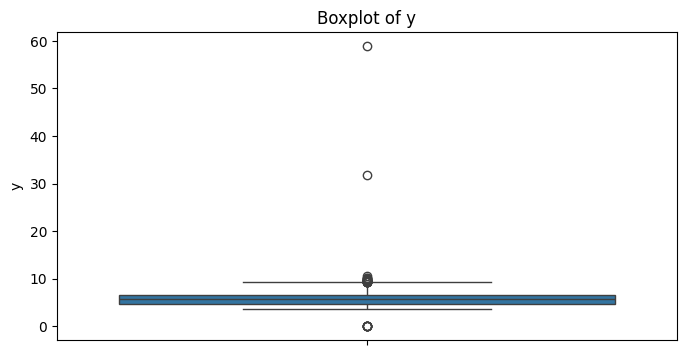

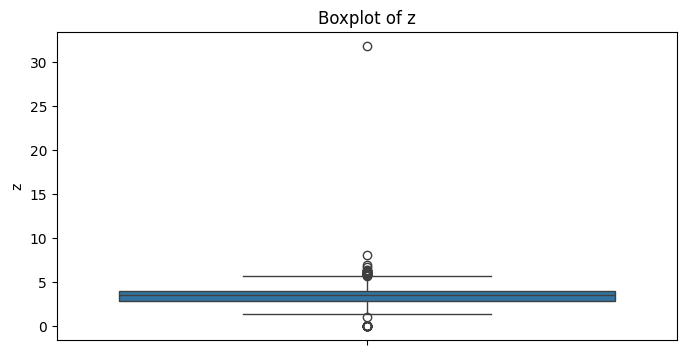

In [2]:
def plot_boxplots(df):
    # Plotting boxplots for each numerical feature to visualize outliers
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

# Call the function to plot boxplots
plot_boxplots(df)

In [9]:
# IQR Kullanarak Aykırı Değerleri Belirleme
# IQR yöntemi, hangi veri noktalarının aykırı değer olarak kabul edildiğini belirlememize yardımcı olacaktır.

def identify_outliers_iqr(df):
    outlier_indices = {}
    
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_indices[column] = outliers.index.tolist()
    
    return outlier_indices

# Identify outliers using IQR method
outliers_dict = identify_outliers_iqr(df)

for col, vals in outliers_dict.items():
    print(f"{col} Sütunundaki aykırı değer sayısı: {len(vals)}")
    oran = (len(vals) * 100) / len(df[col])
    print(f"{col} Sütunundaki aykırı değerlerin oranı %: {round(oran, 2)}")
    print("-"*50)

carat Sütunundaki aykırı değer sayısı: 1889
carat Sütunundaki aykırı değerlerin oranı %: 3.5
--------------------------------------------------
depth Sütunundaki aykırı değer sayısı: 2545
depth Sütunundaki aykırı değerlerin oranı %: 4.72
--------------------------------------------------
table Sütunundaki aykırı değer sayısı: 605
table Sütunundaki aykırı değerlerin oranı %: 1.12
--------------------------------------------------
price Sütunundaki aykırı değer sayısı: 3540
price Sütunundaki aykırı değerlerin oranı %: 6.56
--------------------------------------------------
x Sütunundaki aykırı değer sayısı: 32
x Sütunundaki aykırı değerlerin oranı %: 0.06
--------------------------------------------------
y Sütunundaki aykırı değer sayısı: 29
y Sütunundaki aykırı değerlerin oranı %: 0.05
--------------------------------------------------
z Sütunundaki aykırı değer sayısı: 49
z Sütunundaki aykırı değerlerin oranı %: 0.09
--------------------------------------------------


In [107]:
lof_df.head()

,carat,depth,table,price,x,y,z,LOF_Score,Outlier
0,0.23,61.5,55.0,326,3.95,3.98,2.43,-1,True
1,0.21,59.8,61.0,326,3.89,3.84,2.31,-1,True
2,0.23,56.9,65.0,327,4.05,4.07,2.31,-1,True
3,0.29,62.4,58.0,334,4.20,4.23,2.63,1,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,False


In [ ]:
# LOF modelini ile aykırı değer tespiti yapma: bütün sütunları aynı anda değerlendirerek aykırı gözlem analizi yapar

# LOF, bir gözlemin yerel yoğunluğunu diğer komşu gözlemlerle karşılaştırarak, o gözlemin aykırı olup olmadığını değerlendirir. 
# Yerel yoğunluk, bir veri noktasının yakınındaki veri yoğunluğuna dayanır; 
# bu nedenle LOF, özellikle yoğunluk değişimlerinin olduğu veri kümelerinde başarılıdır.


lof = LocalOutlierFactor(n_neighbors=20, metric="euclidean")

lof_df = df.copy()

# Aykırılık skorlarının hesaplanması
lof_df['LOF_Score'] = lof.fit_predict(lof_df)
lof_df['Outlier'] = lof_df['LOF_Score'] == -1  # LOF aykırı gözlemler için -1, olmayanlar için 1 döner

In [105]:
lof_df[lof_df['LOF_Score'] == -1].shape

(1268, 9)

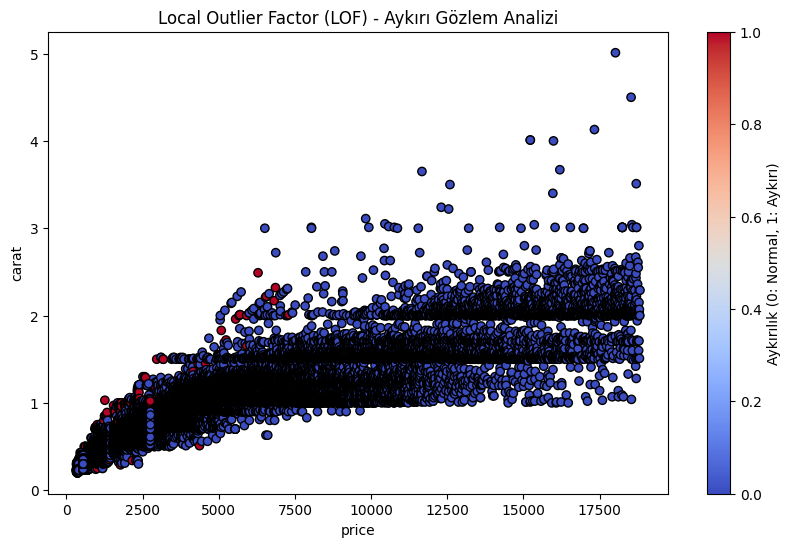

In [111]:
# Görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(lof_df['price'], lof_df['carat'], c=lof_df['Outlier'], cmap='coolwarm', edgecolor='k')
plt.title("Local Outlier Factor (LOF) - Aykırı Gözlem Analizi")
plt.xlabel("price")
plt.ylabel("carat")
plt.colorbar(label="Aykırılık (0: Normal, 1: Aykırı)")
plt.show()

### Aykırı Değerlerin Ele Alınması

In [ ]:
# Belirlenen aykırı değerleri birkaç şekilde ele alabiliriz: 

# Aykırı Değerleri Kaldır: Aykırı değerleri içeren satırları bırakın. 
# Aykırı Değerleri Baskılama: Aykırı değerleri en yakın aykırı olmayan değerle değiştirin. 
# Verileri Dönüştürün: Uç değerlerin etkisini azaltmak için log veya karekök gibi dönüşümler uygulayın.
# Aykırı Değerleri Ortalamalarla Değiştirme:

In [ ]:
# Aykırı Değerleri Kaldır

def remove_outliers(df:pd.DataFrame, outlier_indices:dict):
    indices_set = set()
    for column, indices in outlier_indices.items():
        indices_set.update(indices)
    df.drop(list(indices_set), inplace=True)
    return df

cleaned_df_remove = remove_outliers(df.copy(), outliers_dict)
print("Aykırı değerler kaldırılmadan önce veriseti şekli:", df.shape)
print("Aykırı değerler kaldırıldıktan sonra veriseti şekli:", cleaned_df_remove.shape)
satir_orani = ((df.shape[0] - cleaned_df_remove.shape[0]) * 100) / df.shape[0]
print(f"Silinen satır oranı %: {round(satir_orani, 2)}")

Aykırı değerler kaldırılmadan önce veriseti şekli: (53940, 7)
Aykırı değerler kaldırıldıktan sonra veriseti şekli: (47524, 7)
Silinen satır oranı %: 11.89


In [ ]:
# Aykırı Değerleri Baskıla
# IQR (Interquartile Range) yöntemini kullanarak aykırı değerlerin alt ve üst sınırlarını hesaplar.
# Belirlenen sınırların dışında kalan aykırı değerleri sınır değerlerine eşitler (keser).

def cap_outliers(df, outlier_indices):
    for column, indices in outlier_indices.items():
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the values
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        
    return df

# Cap outliers in the dataset
capped_df = cap_outliers(df.copy(), outliers_dict)
print("Shape after capping outliers:", capped_df.shape) # Satır sayısı aynı kaldı

Shape after capping outliers: (53940, 7)


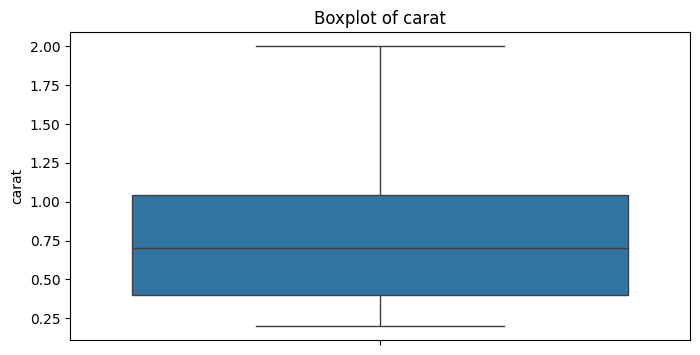

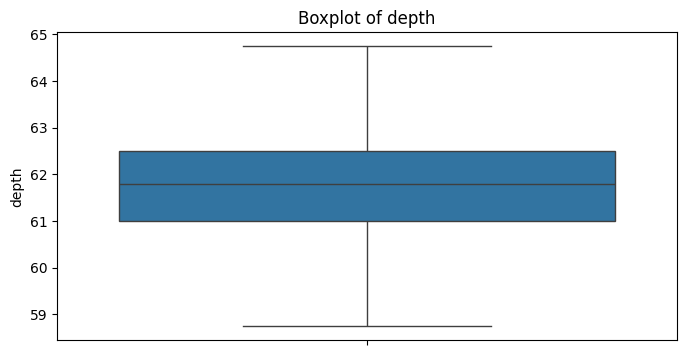

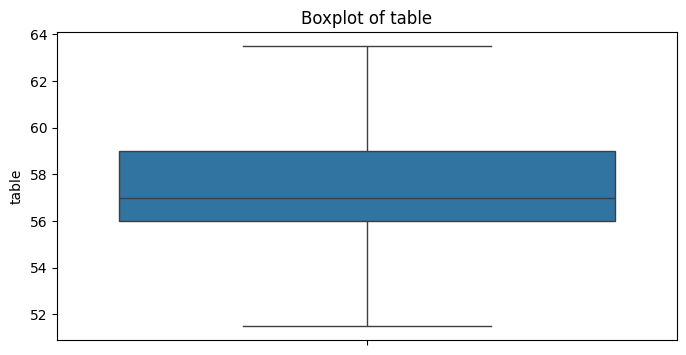

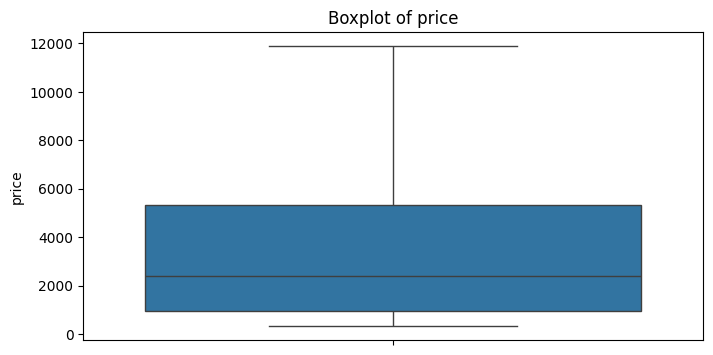

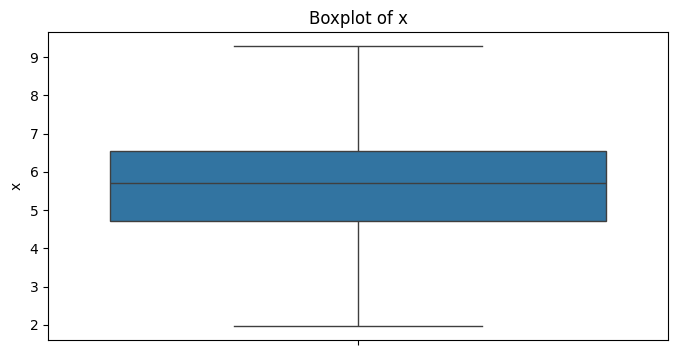

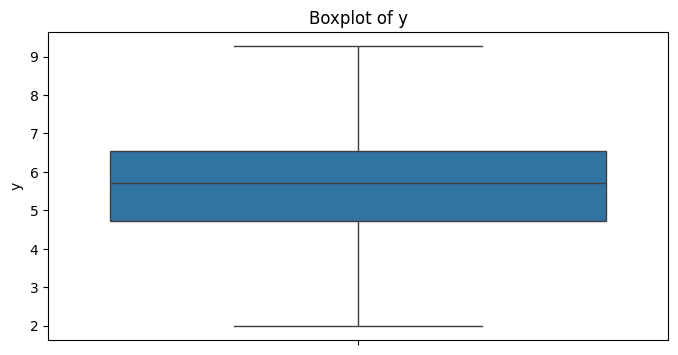

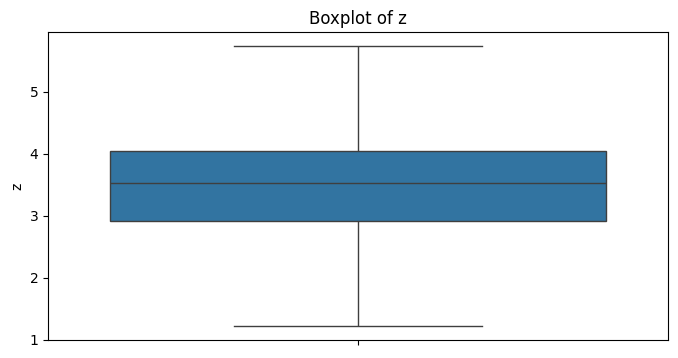

In [ ]:
# Aykırı gözlemlerin olmadığını görelim

def plot_boxplots(df):
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

plot_boxplots(capped_df)

In [21]:
# Verileri Dönüştürün: Verileri ölçeklendirerek çarpıklığı gidermeye çalışacağız

def transform_data(df):
    for column in df.columns:
        if (df[column] <= 0).any():  # Log transformation requires positive values
            continue
        df[column] = np.log(df[column])
    return df

# Transform data to reduce effect of extreme values
transformed_df = transform_data(df.copy())
print("Dönüştürülmüş veriseti:")
transformed_df.head()

Dönüştürülmüş veriseti:


,carat,depth,table,price,x,y,z
0,-1.469676,4.119037,4.007333,5.786897,3.95,3.98,2.43
1,-1.560648,4.091006,4.110874,5.786897,3.89,3.84,2.31
2,-1.469676,4.041295,4.174387,5.789960,4.05,4.07,2.31
3,-1.237874,4.133565,4.060443,5.811141,4.20,4.23,2.63
4,-1.171183,4.147885,4.060443,5.814131,4.34,4.35,2.75


In [26]:
# Aykırı Değerleri Ortalamalarla Değiştirme:

def replace_outliers_with_mean(df, outlier_indices):
    for column, indices in outlier_indices.items():
        mean_value = df[column].mean()
        df.loc[indices, column] = mean_value  # Aykırı değerleri ortalama ile değiştir
    return df

# Aykırı değerleri ortalamalarla değiştirin
cleaned_df_mean = replace_outliers_with_mean(df.copy(), outliers_dict)
print("Yeni Veri Seti:")
cleaned_df_mean.sample(5)

Yeni Veri Seti:


,carat,depth,table,price,x,y,z
50597,0.50,61.8,53.0,2283.0,5.13,5.18,3.19
42882,0.39,60.7,56.0,1359.0,4.73,4.77,2.88
5206,1.00,62.8,59.0,3780.0,6.37,6.27,3.97
33282,0.31,63.7,58.0,462.0,4.27,4.30,2.73
34074,0.40,60.9,61.0,851.0,4.75,4.78,2.90


In [88]:
# çok değişkenli aykırı gözlem analizi

In [ ]:
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.000000,326,3.95,3.98,2.43
1,0.21,59.8,61.000000,326,3.89,3.84,2.31
2,0.23,56.9,57.457184,327,4.05,4.07,2.31
3,0.29,62.4,58.000000,334,4.20,4.23,2.63
4,0.31,63.3,58.000000,335,4.34,4.35,2.75


In [90]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

In [119]:
# aşağıdaki fonksiyon gözlemlerin bütün özelliklerini dikkate alarak aykırı değerleri belirliyor

In [91]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [92]:
clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [93]:
df_scores = clf.negative_outlier_factor_

In [95]:
df_scores[:10]

array([-1.57909232, -1.5941939 , -1.56222304, -1.32495268, -1.30199468,
       -1.27889568, -1.27909345, -1.26110575, -1.27904121, -1.26829766])

In [129]:
np.sort(df_scores[:])[:20] # burada ilk 3 değerin, diğer değerleden çok farklı olduğu görülüyor

array([-8.69700263, -8.26545561, -5.86153222, -4.47421704, -4.27466019,
       -4.2361892 , -4.2361892 , -4.21892191, -4.10492387, -4.0566648 ,
       -4.0539293 , -3.82378797, -3.65947378, -3.60511697, -3.50039893,
       -3.45066056, -3.43137206, -3.42371582, -3.32015348, -3.29322345])

In [122]:
esik_deger = np.sort(df_scores[:])[3] # o yüzden sınır olarak 4. değer seçiliyor

In [123]:
esik_deger

-4.474217040020607

In [124]:
aykiri_degerler = df_scores > esik_deger

In [127]:
yeni_df = df[aykiri_degerler] # aykiri değerleri eleyerek yeni DF oluşturduk

In [128]:
yeni_df

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.000000,326,3.95,3.98,2.43
1,0.21,59.8,61.000000,326,3.89,3.84,2.31
2,0.23,56.9,57.457184,327,4.05,4.07,2.31
3,0.29,62.4,58.000000,334,4.20,4.23,2.63
4,0.31,63.3,58.000000,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...
53935,0.72,60.8,57.000000,2757,5.75,5.76,3.50
53936,0.72,63.1,55.000000,2757,5.69,5.75,3.61
53937,0.70,62.8,60.000000,2757,5.66,5.68,3.56
53938,0.86,61.0,58.000000,2757,6.15,6.12,3.74


# Eksik Gözlem Analizi

In [141]:
C1 = np.array([16,45,23,np.NaN,10,np.NaN,15])
C2 = np.array([np.NaN,5,8,20,np.NaN,65,34])
C3 = np.array([np.NaN,np.NaN,13,25,52,np.NaN,9])
df = pd.DataFrame({
    "C1": C1,
    "C2": C2,
    "C3": C3
})
df

,C1,C2,C3
0,16.0,NaN,NaN
1,45.0,5.0,NaN
2,23.0,8.0,13.0
3,NaN,20.0,25.0
4,10.0,NaN,52.0
5,NaN,65.0,NaN
6,15.0,34.0,9.0


In [132]:
df.isnull().sum()

C1    2
C2    2
C3    3
dtype: int64

In [134]:
df[df.isnull().any(axis=1)] # Eksik değer olan satırları çekmek

,C1,C2,C3
0,16.0,NaN,NaN
1,45.0,5.0,NaN
3,NaN,20.0,25.0
4,10.0,NaN,52.0
5,NaN,65.0,NaN


In [136]:
df[df.notnull().all(axis=1)] # Hiç eksik değer olmayan satırları çekmek

,C1,C2,C3
2,23.0,8.0,13.0
6,15.0,34.0,9.0


In [139]:
df.dropna(inplace=True) # Eksik değer olan satırları silmek

In [140]:
df

,C1,C2,C3
2,23.0,8.0,13.0
6,15.0,34.0,9.0


In [143]:
df["C1"].fillna(df.C1.mean()) # C1 sütunundaki eksik değerleri ortalama ile doldurma

0    16.0
1    45.0
2    23.0
3    21.8
4    10.0
5    21.8
6    15.0
Name: C1, dtype: float64

In [144]:
df["C2"].fillna(0)

0     0.0
1     5.0
2     8.0
3    20.0
4     0.0
5    65.0
6    34.0
Name: C2, dtype: float64

In [156]:
# eksik değerleri görselleştirme

In [158]:
!pip install missingno


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [159]:
import missingno as msno # görselleştirme için kullanılacak kütüphane

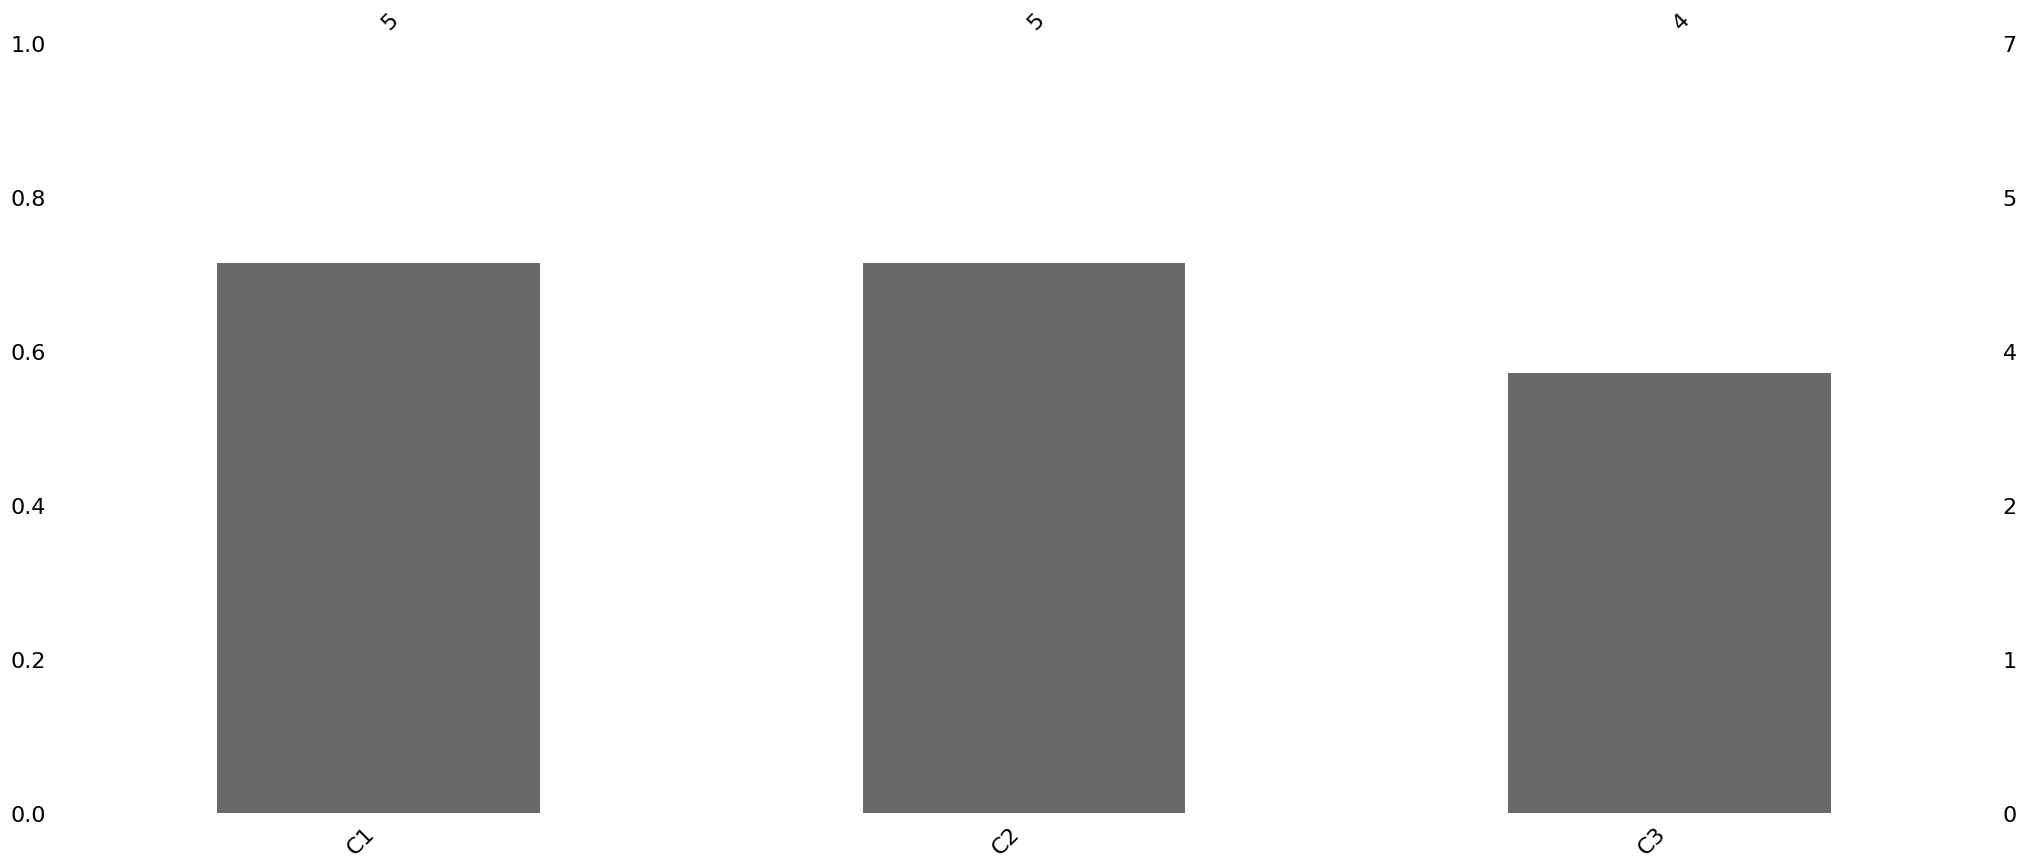

In [151]:
msno.bar(df); # verisetindeki tam gözlemleri gösterir

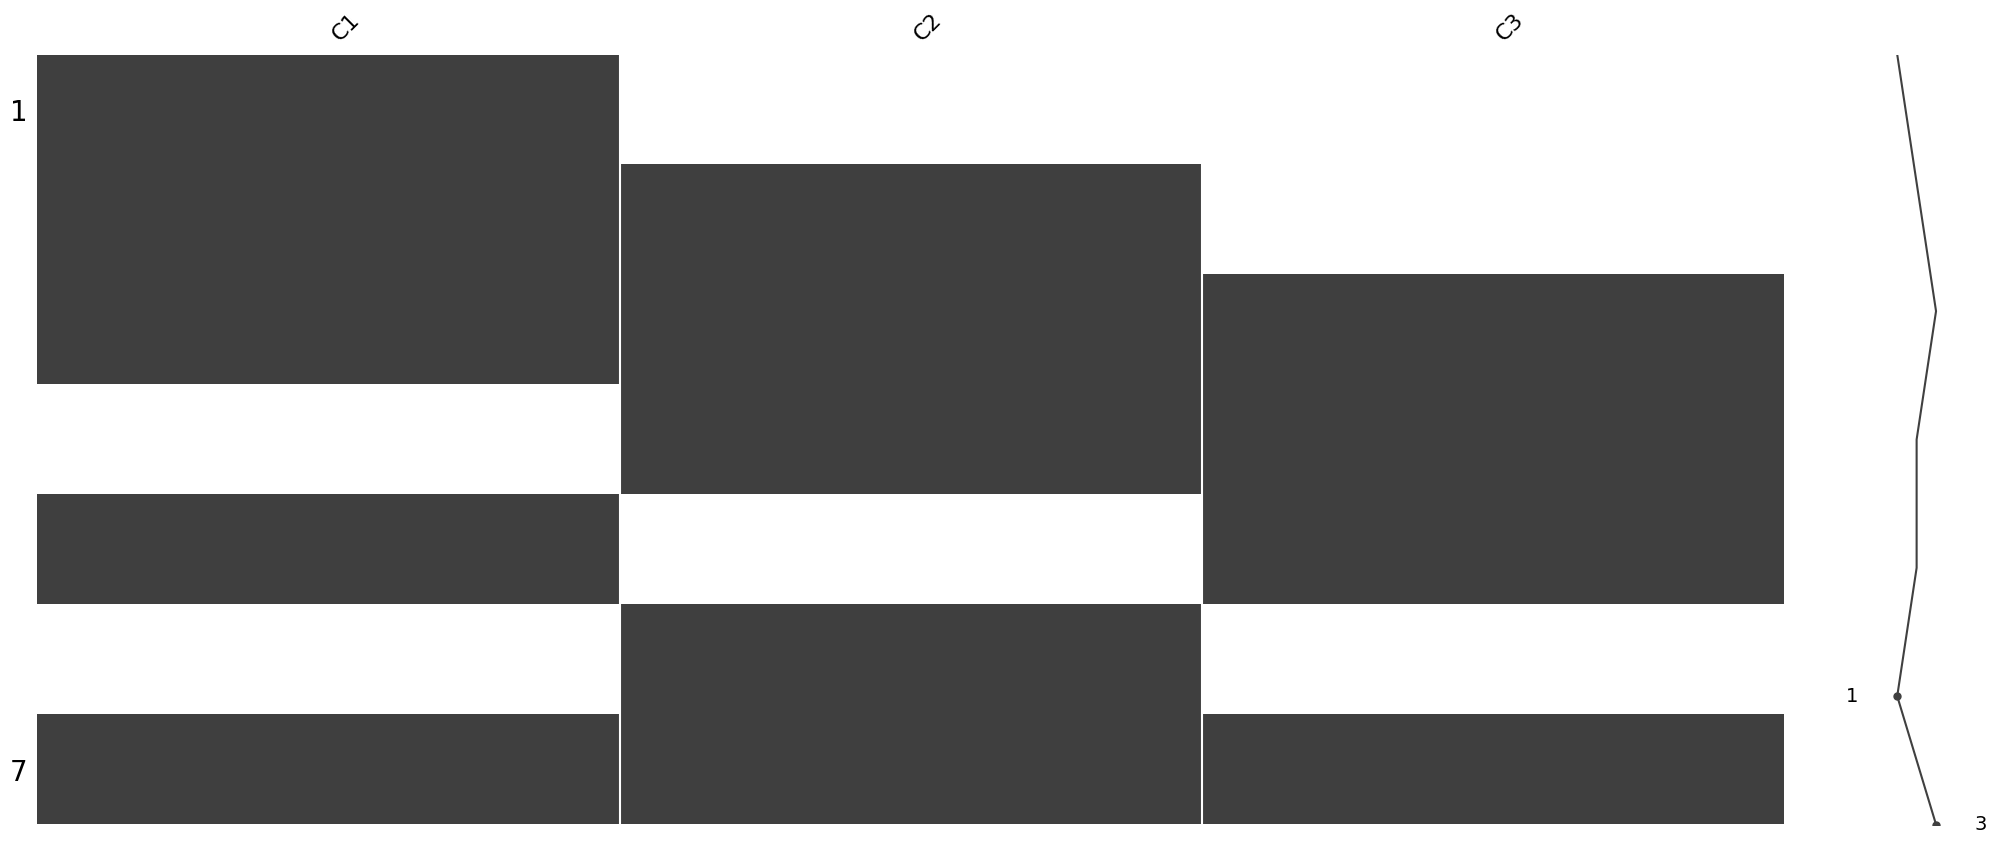

In [150]:
msno.matrix(df); # verisetindeki eksik ve tam değerleri gösterir

In [152]:
df = sns.load_dataset("planets")
df.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [153]:
df.isnull().sum()

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

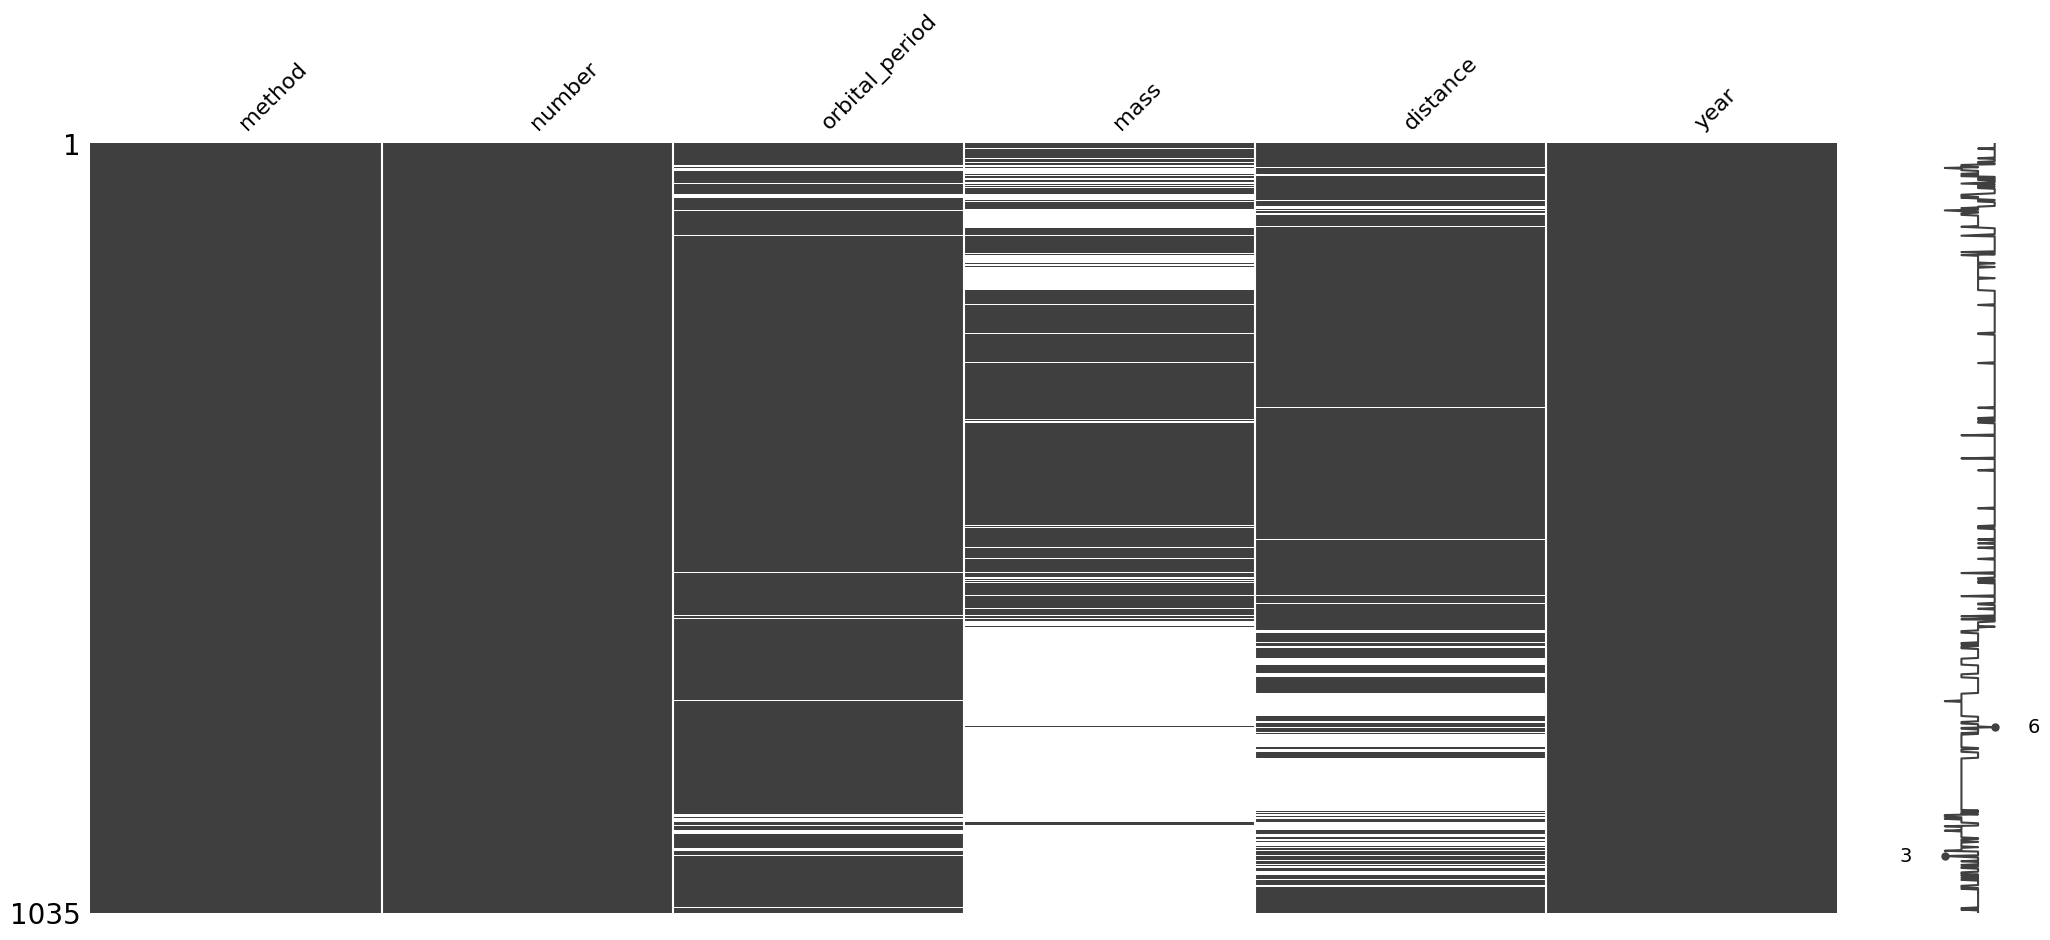

In [154]:
msno.matrix(df);

In [174]:
df.dropna(how="all", inplace=True) # bir satırdaki tüm değerler eksik ise satırı sil

# Değişken Dönüşümleri

### Standardizasyon

In [218]:
from sklearn.preprocessing import scale

In [222]:
df = df.select_dtypes(include=["float64","int64"]) # sadece numerik değerleri seçtik

In [227]:
df.fillna(df.mean(), inplace=True)

In [232]:
scale(df) # tüm değişkenleri belirli bir aralıkta ölçekledi

array([[-0.63328129, -0.06810318,  0.88175718, -0.28835884, -0.77330752],
       [-0.63328129, -0.04431782, -0.15804511, -0.31994914, -0.26961131],
       [-0.63328129, -0.04870874, -0.0126964 , -0.37727511,  0.48593301],
       ...,
       [-0.63328129, -0.07855694,  0.        , -0.13913523, -0.52145941],
       [-0.63328129, -0.07852027,  0.        ,  0.04469095, -0.26961131],
       [-0.63328129, -0.0785178 ,  0.        , -0.00628606, -0.26961131]])

### Normalizasyon

In [229]:
from sklearn.preprocessing import normalize

In [231]:
normalize(df) # tüm değişkenleri 0 ile 1 arasında ölçekledi

array([[4.93709771e-04, 1.32956041e-01, 2.46854885e-03, 3.82131363e-02,
        9.90381800e-01],
       [4.56409662e-04, 3.99255306e-01, 1.00866535e-03, 2.59925303e-02,
        9.16470602e-01],
       [4.64905554e-04, 3.54722937e-01, 1.20875444e-03, 9.22372618e-03,
        9.34925068e-01],
       ...,
       [4.96392966e-04, 1.58425001e-03, 1.30753234e-03, 8.63723760e-02,
        9.96260682e-01],
       [4.92787974e-04, 2.03279119e-03, 1.29803655e-03, 1.44386876e-01,
        9.89518251e-01],
       [4.93883501e-04, 2.06826409e-03, 1.30092224e-03, 1.28409710e-01,
        9.91718071e-01]])

# Min-Max Dönüşümü

In [234]:
from sklearn.preprocessing import MinMaxScaler

In [241]:
scaler = MinMaxScaler(feature_range=(0, 10)) # kendi belirlediğimiz aralıkta değişkenleri ölçekler

In [242]:
scaler.fit_transform(df) # değişkenleri belirlediğimiz aralığa uydurduk

array([[0.00000000e+00, 3.68779900e-03, 1.99884783e+00, 8.94848005e-02,
        6.80000000e+00],
       [0.00000000e+00, 1.19819644e-02, 8.82687107e-01, 6.54221553e-02,
        7.60000000e+00],
       [0.00000000e+00, 1.04508135e-02, 1.03870957e+00, 2.17563966e-02,
        8.80000000e+00],
       ...,
       [0.00000000e+00, 4.24769588e-05, 1.05233834e+00, 2.03149912e-01,
        7.20000000e+00],
       [0.00000000e+00, 5.52654385e-05, 1.05233834e+00, 3.43172151e-01,
        7.60000000e+00],
       [0.00000000e+00, 5.61239893e-05, 1.05233834e+00, 3.04342454e-01,
        7.60000000e+00]])

### Değişken Dönüşümleri

In [266]:
df = sns.load_dataset('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [267]:
from sklearn.preprocessing import LabelEncoder

In [268]:
le = LabelEncoder() # kategorik değişkenleri sayısal değerlere dönüştürür

In [269]:
le.fit_transform(df["sex"]) # kadın=0 erkek=1 olarak kodlandı

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0])

In [270]:
df["gunler"] = np.where(df["day"].str.contains("Sun"), 1, 0) # day sütunundaki 'Sun' olanlara 1 diğerlerine 0 diyip yeni bir sütuna atadık

In [271]:
df.head()

,total_bill,tip,sex,smoker,day,time,size,gunler
0,16.99,1.01,Female,No,Sun,Dinner,2,1
1,10.34,1.66,Male,No,Sun,Dinner,3,1
2,21.01,3.50,Male,No,Sun,Dinner,3,1
3,23.68,3.31,Male,No,Sun,Dinner,2,1
4,24.59,3.61,Female,No,Sun,Dinner,4,1


### One-Hot Dönüşümü

In [272]:
df = pd.get_dummies(df, columns=["time"], prefix="Zaman")

In [273]:
df.head()

,total_bill,tip,sex,smoker,day,size,gunler,Zaman_Lunch,Zaman_Dinner
0,16.99,1.01,Female,No,Sun,2,1,False,True
1,10.34,1.66,Male,No,Sun,3,1,False,True
2,21.01,3.50,Male,No,Sun,3,1,False,True
3,23.68,3.31,Male,No,Sun,2,1,False,True
4,24.59,3.61,Female,No,Sun,4,1,False,True


In [274]:
df.replace(to_replace=False, value=0, inplace=True)
df.replace(to_replace=True, value=1, inplace=True)

In [275]:
df.head()

,total_bill,tip,sex,smoker,day,size,gunler,Zaman_Lunch,Zaman_Dinner
0,16.99,1.01,Female,No,Sun,2,1,0,1
1,10.34,1.66,Male,No,Sun,3,1,0,1
2,21.01,3.50,Male,No,Sun,3,1,0,1
3,23.68,3.31,Male,No,Sun,2,1,0,1
4,24.59,3.61,Female,No,Sun,4,1,0,1
